In [499]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer

In [500]:
cwd = os.getcwd()
# load data
fpath = "./data/raw/0_Combined_Team_Per90.csv"
if os.path.isfile(fpath) == False:
    print('Error - fpath is invalid')
else:
    df = pd.read_csv(fpath)

In [501]:
# create df for cluster assignment
prep_df = df.drop(columns=["Unnamed: 0", "Season", "TeamID", "League", "Squad", "90s", "# Pl", "# Pl"])

In [502]:
# transform and standardize variables
km_df = PowerTransformer().fit_transform(prep_df)

# fit PCA; want > 90% explained variance
pca_orig = PCA().fit(km_df)
print("Explained variance: ", pca_orig.explained_variance_ratio_[:33].sum())
km_df = PCA(33).fit_transform(km_df)

/Users/agushansky/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Explained variance:  0.9007612254424873


/Users/agushansky/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/agushansky/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


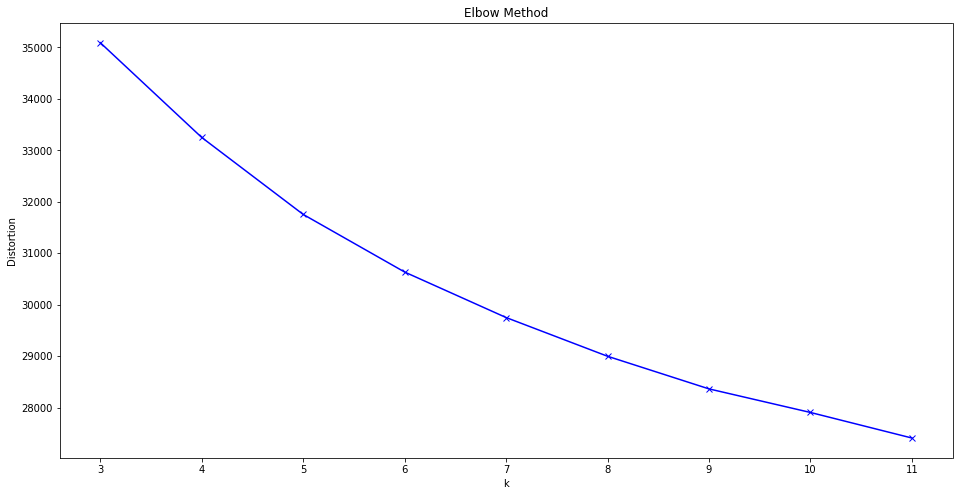

In [503]:
# run kmeans; select select k=7 
# elbow chart adapted from https://predictivehacks.com/k-means-elbow-method-code-for-python/

distortions = []
K = range(3,12)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(km_df)
    distortions.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [504]:
# fit final kmeans
kmeans = KMeans(6).fit(km_df)

# add cluster assignments to df, and create a separate df to plot cluster results
km_labels = pd.DataFrame(kmeans.labels_, columns=["team_play_style"]).squeeze()
plot_kmeans_df = pd.concat([pd.DataFrame(km_df), km_labels, df.Squad, df.Season, df.League], axis=1)
plot_kmeans_df['squad_season'] = plot_kmeans_df['Squad'].str.cat(plot_kmeans_df['Season'].str[-2:], sep="_")

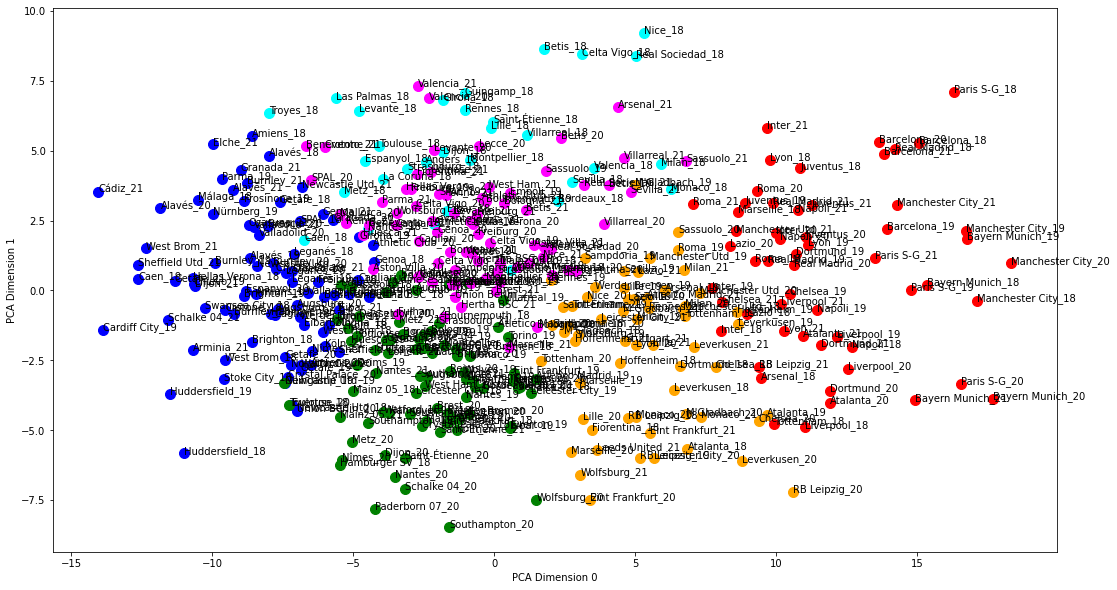

In [505]:
# plot clusters

plt.figure(figsize=(18, 10))

colors = ["orange", "blue", "green", "cyan", "magenta", "red", "yellow", "purple"] # add more colors as K increases

for k in range(km_labels.max()+1):
    X = plot_kmeans_df[plot_kmeans_df.team_play_style == k][0].to_list()
    y = plot_kmeans_df[plot_kmeans_df.team_play_style == k][1].to_list()
    plt.scatter(X, y, s=100, c=colors[k])
    plt.xlabel("PCA Dimension 0")
    plt.ylabel("PCA Dimension 1")
    annotations = plot_kmeans_df[plot_kmeans_df.team_play_style == k]["squad_season"].tolist()
    for i, label in enumerate(annotations):
        plt.annotate(label, (X[i], y[i]))

In [506]:
# one-hot-encode cluster assignments
team_play_style = pd.get_dummies(km_labels, prefix='team_play_style')

In [507]:
# get average by metric for each cluster 
prep_df = pd.concat([prep_df, km_labels], axis=1)
prep_df = prep_df.groupby("team_play_style").mean()
prep_df.head(10)

,Gls,Sh_x,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,SCA,SCA90,PassLive,PassDead,Drib,Sh_y,Fld_x,Def,GCA,GCA90,PassLive.1,PassDead.1,Drib.1,Sh.1,Fld.1,Def.1,Total Cmp,Total Att,Total Cmp%,Total TotDist,Total PrgDist,Short Cmp,Short Att,Short Cmp%,Medium Cmp,Medium Att,Medium Cmp%,Long Cmp,Long Att,Long Cmp%,Ast,xA,A-xA,KP,1/3_x,PPA,CrsPA,Prog_x,Att_x,Pass Types: Live,Pass Types: Dead,Pass Types: FK,Pass Types: TB,Pass Types: Press,Pass Types: Sw,Pass Types: Crs,Pass Types: CK,Corner Kicks: In,Corner Kicks: Out,Corner Kicks: Str,Height: Ground,Height: Low,Height: High,Body Parts: Left,Body Parts: Right,Body Parts: Head,Body Parts: TI,Body Parts: Other,Outcomes: Cmp,Outcomes: Off,Outcomes: Out,Outcomes: Int,Outcomes: Blocks,Tackles: Tkl,Tackles: TklW,Tackles: Def 3rd,Tackles: Mid 3rd,Tackles: Att 3rd,Vs Dribbles: Tkl,Vs Dribbles: Att,Vs Dribbles: Tkl%,Vs Dribbles: Past,Pressures: Press,Pressures: Succ,Pressures: %,Pressures: Def 3rd,Pressures: Mid 3rd,Pressures: Att 3rd,Blocks: Blocks,Blocks: Sh,Blocks: ShSv,Blocks: Pass,Int_x,Tkl+Int,Clr,Err,Poss,Touches,Def Pen,Def 3rd,Mid 3rd,Att 3rd,Att Pen,Live,Succ,Att_y,Succ%,#Pl,Megs,Carries,TotDist,PrgDist,Prog_y,1/3_y,CPA,Mis,Dis,Targ,Rec,Rec%,Prog.1,CrdY,CrdR,2CrdY,Fls,Fld_y,Off,Crs,Int_y,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Age,MP,Min,Mn/MP,Min%,Starts,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,onxG,onxGA,xG+/-,xG+/-90
team_play_style,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.655738,13.774590,4.815902,35.045902,13.774590,4.815902,0.110328,0.313934,17.190164,0.534262,0.151475,0.187869,1.549836,1.410164,0.104754,0.105082,0.094918,22.053279,22.053279,16.080164,1.834426,1.430820,1.116393,1.146885,0.443279,2.740000,2.740000,1.898033,0.160820,0.218033,0.210656,0.200328,0.055574,444.136721,546.131967,81.204918,8638.722131,2842.542951,177.615246,201.653279,87.931148,195.151803,223.396066,87.222951,64.180328,102.556557,62.426230,1.186066,1.068361,0.119836,10.214426,32.636885,9.204098,2.268689,38.569016,546.131967,496.876721,49.253934,13.385902,1.162295,82.503607,15.167705,12.346066,5.372459,1.505082,1.597541,0.351803,374.904590,73.909180,97.317705,152.200328,334.847377,20.225082,21.111475,7.448689,444.136721,1.677869,8.746885,9.680000,12.823607,17.998689,11.297377,8.601803,7.168852,2.229508,6.169508,17.428033,35.413115,11.259180,155.388197,45.917049,29.573770,48.893770,71.090492,35.403934,15.572459,3.159180,0.058033,12.412459,9.030492,27.029180,22.241311,0.228033,54.427869,664.533443,64.202131,208.765574,330.843279,168.097869,25.472623,616.783443,11.059508,18.131148,60.986885,11.916721,0.613443,443.005246,2267.720984,1244.393934,49.579836,14.682951,4.452459,12.718525,12.135574,516.083443,444.136721,85.985246,43.927869,1.649672,0.075738,0.040820,12.301475,11.942623,1.948033,12.346066,9.030492,11.297377,0.141311,0.151639,0.039836,92.836066,14.931148,14.432131,50.686885,25.949180,35.737705,90.0,90.000000,100.0,11.0,70.081967,2.396230,3.213934,16.934426,5.207377,1.677213,1.699180,1.249836,16.295082,0.449672,1.549836,1.247869,10.901639,0.302131
1,0.923494,10.046145,3.133614,31.207229,10.046145,3.133614,0.083735,0.266506,17.691566,0.420361,0.091687,0.126386,0.999036,0.904458,0.091687,-0.075904,-0.071807,15.063976,15.063976,10.335542,1.659759,0.914819,0.772530,1.026024,0.354578,1.444578,1.444578,0.927108,0.119518,0.094096,0.141325,0.127590,0.038313,301.241205,409.724819,73.238554,6179.165904,2342.560241,118.811205,140.988675,84.020482,124.711928,152.974819,81.150602,52.208675,99.854096,52.227711,0.614940,0.646386,-0.021325,7.016265,22.983735,6.006506,1.995060,26.293614,409.724819,360.100964,49.623373,13.151446,0.549157,68.680241,13.447349,11.170843,4.094940,1.348193,1.105181,0.283253,231.872892,63.503855,114.348193,113.401325,230.545542,23.582771,21.433012,6.014337,301.241205,1.736024,10.013855,7.976024,11.577229,17.124940,1

In [508]:
df = pd.concat([df, team_play_style], axis=1)

In [509]:
df.head(10)

,Unnamed: 0,TeamID,Season,League,Squad,# Pl,90s,Gls,Sh_x,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,SCA,SCA90,PassLive,PassDead,Drib,Sh_y,Fld_x,Def,GCA,GCA90,PassLive.1,PassDead.1,Drib.1,Sh.1,Fld.1,Def.1,Total Cmp,Total Att,Total Cmp%,Total TotDist,Total PrgDist,Short Cmp,Short Att,Short Cmp%,Medium Cmp,Medium Att,Medium Cmp%,Long Cmp,Long Att,Long Cmp%,Ast,xA,A-xA,KP,1/3_x,PPA,CrsPA,Prog_x,Att_x,Pass Types: Live,Pass Types: Dead,Pass Types: FK,Pass Types: TB,Pass Types: Press,Pass Types: Sw,Pass Types: Crs,Pass Types: CK,Corner Kicks: In,Corner Kicks: Out,Corner Kicks: Str,Height: Ground,Height: Low,Height: High,Body Parts: Left,Body Parts: Right,Body Parts: Head,Body Parts: TI,Body Parts: Other,Outcomes: Cmp,Outcomes: Off,Outcomes: Out,Outcomes: Int,Outcomes: Blocks,Tackles: Tkl,Tackles: TklW,Tackles: Def 3rd,Tackles: Mid 3rd,Tackles: Att 3rd,Vs Dribbles: Tkl,Vs Dribbles: Att,Vs Dribbles: Tkl%,Vs Dribbles: Past,Pressures: Press,Pressures: Succ,Pressures: %,Pressures: Def 3rd,Pressures: Mid 3rd,Pressures: Att 3rd,Blocks: Blocks,Blocks: Sh,Blocks: ShSv,Blocks: Pass,Int_x,Tkl+Int,Clr,Err,Poss,Touches,Def Pen,Def 3rd,Mid 3rd,Att 3rd,Att Pen,Live,Succ,Att_y,Succ%,#Pl,Megs,Carries,TotDist,PrgDist,Prog_y,1/3_y,CPA,Mis,Dis,Targ,Rec,Rec%,Prog.1,CrdY,CrdR,2CrdY,Fls,Fld_y,Off,Crs,Int_y,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Age,MP,Min,Mn/MP,Min%,Starts,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,onxG,onxGA,xG+/-,xG+/-90,team_play_style_0,team_play_style_1,team_play_style_2,team_play_style_3,team_play_style_4,team_play_style_5
0,0,37745278530914180,2017-2018,La Liga,Alavés,30,38.0,1.05,10.34,3.61,34.9,10.34,3.61,0.10,0.28,18.3,0.58,0.03,0.08,1.02,0.96,0.09,0.03,0.06,15.58,15.58,10.76,1.45,1.00,0.58,1.50,0.29,1.74,1.74,1.29,0.08,0.08,0.13,0.16,0.00,245.95,354.24,69.4,5007.63,2062.79,100.37,125.89,79.7,100.84,131.82,76.5,41.61,85.58,48.6,0.82,0.68,0.13,7.00,21.50,5.08,1.89,23.66,354.24,314.89,39.34,10.84,0.42,72.37,10.92,9.76,3.42,0.05,0.05,0.00,201.50,42.50,110.24,123.45,168.55,31.34,17.05,4.55,245.95,2.37,11.55,7.89,11.05,15.95,10.08,8.82,5.39,1.74,4.95,16.08,30.8,11.13,167.24,40.03,23.9,56.87,79.58,30.79,15.92,3.61,0.03,12.32,9.16,25.11,17.92,0.26,39.8,463.87,56.58,162.16,216.87,111.45,16.82,425.37,9.42,14.53,64.9,10.39,0.61,279.97,1388.74,698.32,26.42,8.47,2.89,11.79,9.74,307.45,245.95,80.0,32.71,2.76,0.11,0.11,16.16,13.97,2.92,9.76,9.16,10.08,0.08,0.26,0.05,92.34,9.89,10.03,49.7,25.5,38,90.0,90,100,11.0,85.0,7.97,2.92,20,4.05,1.24,1.05,1.32,-10,-0.26,1.02,1.40,-14.4,-0.38,0,1,0,0,0,0
1,1,37745278530914180,2018-2019,La Liga,Alavés,26,38.0,1.03,11.03,3.11,28.2,11.03,3.11,0.09,0.31,17.7,0.39,0.05,0.08,0.98,0.92,0.08,0.04,0.05,15.53,15.53,9.87,2.03,1.05,0.95,1.24,0.39,1.55,1.55,0.95,0.18,0.08,0.18,0.13,0.03,258.26,366.29,70.5,5355.53,2307.97,103.11,125.11,82.4,102.74,130.50,78.7,47.61,96.71,49.2,0.71,0.63,0.08,7.16,21.87,5.95,2.74,25.29,366.29,314.92,51.37,15.39,0.34,55.68,11.39,13.34,3.82,0.71,0.66,0.13,190.34,56.68,119.26,120.58,177.87,27.21,21.18,4.79,258.26,1.26,10.21,6.66,10.97,16.74,9.61,8.66,6.16,1.92,5.95,17.34,34.3,11.39,154.39,36.47,23.6,51.66,72.50,30.24,15.95,3.05,0.05,12.89,9.03,25.76,30.21,0.21,42.7,489.08,61.34,168.68,232.79,113.55,17.68,438.66,8.45,15.11,55.9,9.03,0.39,270.63,1324.76,722.66,27.24,8.68,1.76,13.47,9.13,333.11,258.26,77.5,35.37,2.66,0.03,0.00,14.50,13.13,1.53,13.34,9.03,9.61,0.05,0.16,0.05,92.42,18.47,18.97,49.3,26.7,38,90.0,90,100,11.0,85.0,0.00,2.97,17,4.03,1.32,1.03,1.32,-11,-0.29,0.98,1.34,-13.7,-0.36,0,1,0,0,0,0
2,2,37745278530914180,2019-2020,La Liga,Alavés,32,38.0,0.89,7.87,2.61,33.1,7.87,2.61,0.09,0.28,16.5,0.26,0.16,0.16,0.97,0.86,0.11,-0.08,-0.12,12.24,12.24,7.76,1.89,0.53,0.71,1.05,0.29,1.39,1.39,0.82,0.18,0.03,0.16,0.18,0.03,255.89,361.92,70.7,5448.92,2276.63,100.74,123.55,81.5,102.47,130.53,78.5,47.74,92.87,51.4,0.53,0.62,-0.09,5.79,19.76,4.66,1.32,22.58,361.92,309.24,52.68,14.32,0.66,68.37,12.05,9.82,3.58,1.11,1.34,0.29,180.89,61.79,119.24,113.00